In [125]:
import os, math
import matplotlib
from math import radians, cos, sin, asin, sqrt
from bs4 import BeautifulSoup
import json
import pandas as pd
import csv
from pandas import DataFrame, Series
import numpy as np
def calculateArea(stop = dict(), reachablestop = list(), r = 1):
    totalpoint = 0
    width = (-89.2 + 89.55) * 15/0.06
    height = (43.2 - 42.075) *10/0.04
    totalpoint = width * height
    all_inside = list()
    stepsizeX = 0.06/15
    stepsizeY = 0.04/10
    modified_stop = remove_dup(reachablestop)
    for i in range(len(modified_stop)):
        col_start = ((stop[modified_stop[i]][0] - 0.03)//stepsizeX-1)*stepsizeX
        row_start = ((stop[modified_stop[i]][1] - 0.02)//stepsizeY-1)*stepsizeY
        x = col_start
        y = row_start
        for j in range(10):
            x = col_start
            for k in range(15):
                if haversine(x,y,stop[modified_stop[i]][0],stop[modified_stop[i]][1]) <= r:
                    if not [x,y] in all_inside:
                        all_inside.append([x,y])
                x += stepsizeX
                x = round(x,3)
            y += stepsizeY
            y = round(y,3)
    return haversine(-89.55, 43.2, -89.55, 42.075)*haversine(-89.55, 42.075, -89.2, 42.075)*len(all_inside)/totalpoint
def remove_dup(reachablestop):
    result = list()
    for i in range(len(reachablestop)):
        if not get_stop(reachablestop[i]) in result:
            result.append(get_stop(reachablestop[i]))
    return result
# def setdimensions(reachablestop = list(), stop = dict()):
#     lowestLon = None
#     lowestLat = None
#     highestLon = None
#     highestLat = None
#     for i in range(len(reachablestop)):
#         if lowestLon == None or lowestLon > stop[get_stop(reachablestop[i])][0] - 0.03:
#             lowestLon = stop[get_stop(reachablestop[i])][0] - 0.03
#         if lowestLat == None or lowestLat > stop[get_stop(reachablestop[i])][1] - 0.02:
#             lowestLat = stop[get_stop(reachablestop[i])][1] - 0.02
#         if highestLon == None or highestLon < stop[get_stop(reachablestop[i])][0] + 0.03:
#             highestLon = stop[get_stop(reachablestop[i])][0] + 0.03
#         if highestLat == None or highestLat < stop[get_stop(reachablestop[i])][1] + 0.02:
#             highestLat = stop[get_stop(reachablestop[i])][1] + 0.02
#     dimension = list()
#     dimension.append(lowestLon)
#     dimension.append(lowestLat)
#     dimension.append(highestLon)
#     dimension.append(highestLat)
#     return dimension

#copied from: https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [3]:
def read_csv(filename):
    file = open(filename, encoding='utf-8')
    file_reader = csv.reader(file)
    data = list(file_reader)
    file.close()
    header = data[0]
    data = data[1:]
    stop = dict()
    for row in data:
        latlon = row[4:6]
        temp = latlon[0]
        latlon[0] = float(latlon[1])
        latlon[1] = float(temp)
        if not row[0] in stop:
            stop[int(row[0])] = latlon
    return stop

In [4]:
import pickle, copy

with open("DFS_BUS_GRAPH.pkl", "rb") as f:
    g = pickle.load(f)

def get_stop(node):
    return int(node.split("_")[0])
   
def get_seconds(node):
    return int(node.split("_")[1])
   
# depth-first search through bus system
#
# graph: dict, key=node name, val=edge list
# node: node name
# max_time: last time (in seconds) beyond which we don't search (None if no limit)
# visited: set of nodes visited already (to avoid repeats)
def dfs(graph, node, max_time=None, visited=None):
    if visited == None:
        visited = set()

    node_time = get_seconds(node)
    if max_time != None and node_time > max_time:
        return visited

    if node in visited:
        return visited

    visited.add(node)
    for edge in graph[node]:
        dfs(graph, edge["destination"], max_time, visited)

    return visited

def stops_reachable_percent(start, hours=None):
    limit = None
    if hours != None:
        limit = get_seconds(start) + hours * 3600 # hours to seconds
    reachable = dfs(g, start, limit)
    reachable_stops = {get_stop(node) for node in reachable}
    all_stops = {get_stop(node) for node in g.keys()}
    return len(reachable_stops) / len(all_stops)
# for key in g:
#     print(g[key])
#     break
# where can we get if we start at this place/time, and have no time limit?
#print(stops_reachable_percent('1561_25223'))
#print(g)
# one hour limit?
print(dfs(g, '4443_31844'))
k = list(dfs(g, '1561_25223', 25224+60*60*2))
allstop = list()
count = 0
starter = dict()
for key in g:
    if not get_stop(key) in starter:
        starter[get_stop(key)] = get_seconds(key)
    else:
        if starter[get_stop(key)] > get_seconds(key):
            starter[get_stop(key)] = get_seconds(key)
starter

{'173_32049', '121_32010', '4845_31942', '353_31982', '4443_31844'}


{1561: 25223,
 1877: 25259,
 1759: 25281,
 5100: 25200,
 435: 25202,
 941: 25231,
 839: 25323,
 883: 25394,
 1324: 25375,
 1101: 25200,
 1787: 25239,
 1495: 25573,
 1261: 25624,
 1831: 25683,
 1397: 25718,
 1121: 25742,
 1151: 25787,
 1209: 25860,
 1767: 25925,
 1157: 25983,
 1577: 26044,
 1329: 26100,
 1533: 26159,
 1717: 26196,
 1923: 26236,
 1715: 26273,
 2131: 25260,
 2473: 25350,
 2349: 25287,
 2916: 25446,
 2822: 25497,
 2561: 25556,
 2605: 25611,
 2717: 25667,
 2921: 25727,
 133: 25320,
 809: 25367,
 581: 25474,
 741: 25507,
 455: 25221,
 6100: 25200,
 2925: 25262,
 2401: 25332,
 2249: 25375,
 2669: 25412,
 2201: 25306,
 2121: 25370,
 2175: 25440,
 2101: 25474,
 2395: 25662,
 2752: 25699,
 2501: 25754,
 2741: 25786,
 2191: 25249,
 2755: 25929,
 2595: 25221,
 2945: 25302,
 1325: 26692,
 1267: 25228,
 1707: 27910,
 1177: 27957,
 1379: 28020,
 2146: 25207,
 2192: 25260,
 2643: 25320,
 2393: 25344,
 2125: 25348,
 2620: 25391,
 2770: 25440,
 2576: 25231,
 2698: 25283,
 2270: 25323,
 

In [5]:
stop = read_csv("stops.csv")
stop

{1110: [-89.38592, 43.076428],
 1111: [-89.382354, 43.072938],
 1124: [-89.385273, 43.072467],
 1135: [-89.383413, 43.077272],
 1140: [-89.38193, 43.07639],
 1146: [-89.386724, 43.073504],
 1155: [-89.381192, 43.075579],
 1174: [-89.387855, 43.07512],
 1189: [-89.380724, 43.074111],
 4000: [-89.394651, 43.038957],
 4100: [-89.394824, 43.038895],
 5000: [-89.358526, 43.112918],
 5100: [-89.35854, 43.113253],
 6000: [-89.475454, 43.053863],
 6100: [-89.475098, 43.053883],
 7000: [-89.322251, 43.098624],
 7100: [-89.322148, 43.098619],
 9000: [-89.307135, 43.126161],
 9800: [-89.306961, 43.126576],
 5: [-89.406982, 43.070947],
 10: [-89.400154, 43.075933],
 25: [-89.396944, 43.075691],
 39: [-89.397341, 43.071895],
 45: [-89.38982, 43.078482],
 47: [-89.412598, 43.074636],
 49: [-89.397191, 43.075529],
 50: [-89.402267, 43.069442],
 52: [-89.40566, 43.076131],
 53: [-89.403882, 43.075781],
 54: [-89.403872, 43.06947],
 56: [-89.407141, 43.07665],
 60: [-89.40366, 43.075996],
 61: [-89.403

In [78]:
area_5100_2h = calculateArea(stop, list(dfs(g, '1561_25223', 25224 + 60*60*1.5)),1)

In [79]:
area_5100_2h

85.15217193700411

In [128]:
%matplotlib inline

In [129]:
def plot_detail(stops_df, stop_id):
    area = list()
    if stops_df.loc[stop_id, 'size'] != 1:
        for i in range(5):
            area.append(calculateArea(stop, list(dfs(g, str(stop_id) + '_' + str(starter[stop_id]), starter[stop_id] + 60*60*((i+1) * 0.5))), 1))
    print(area)
    return area

In [130]:
import matplotlib.pyplot as plt

In [94]:
def add_measure(stop_id, area_reachable):
    stops_df.loc[stop_id, "color"] = "red"
    radius = (area_reachable / 3.14) ** 0.5
    mult = 100
    stops_df.loc[stop_id, "size"] = radius ** 0.5 * mult
    
add_measure(1561, 25)

In [95]:
stops_df = pd.read_csv("stops.csv").set_index("stop_id")[["stop_lat", "stop_lon"]]
stops_df["size"] = 1
stops_df["color"] = "0.8"
for i in stops_df.index:
    if i in starter:
        area = calculateArea(stop, list(dfs(g, str(i) + '_' + str(starter[i]), starter[i] + 60*60)), 1)
        add_measure(i, area)
        print('finished' + str(i))
stops_df.head()

finished4100
finished5100
finished6100
finished7100
finished9800
finished5
finished10
finished39
finished47
finished49
finished50
finished52
finished54
finished60
finished61
finished75
finished87
finished100
finished104
finished107
finished113
finished115
finished121
finished124
finished133
finished146
finished147
finished150
finished153
finished158
finished160
finished161
finished162
finished166
finished167
finished168
finished170
finished171
finished173
finished174
finished178
finished180
finished181
finished184
finished190
finished192
finished195
finished203
finished208
finished217
finished222
finished225
finished226
finished234
finished235
finished243
finished248
finished251
finished252
finished256
finished265
finished266
finished274
finished288
finished289
finished294
finished298
finished300
finished313
finished320
finished327
finished336
finished346
finished349
finished353
finished357
finished360
finished367
finished375
finished379
finished388
finished391
finished392
finished398


finished2801
finished2806
finished2812
finished2822
finished2829
finished2836
finished2840
finished2846
finished2850
finished2855
finished2856
finished2867
finished2872
finished2874
finished2880
finished2881
finished2883
finished2885
finished2889
finished2890
finished2892
finished2898
finished2899
finished2901
finished2902
finished2916
finished2918
finished2921
finished2923
finished2925
finished2937
finished2938
finished2939
finished2940
finished2945
finished2946
finished2949
finished2965
finished2969
finished2972
finished2975
finished2978
finished2980
finished2982
finished2984
finished2996
finished2998
finished3100
finished3105
finished3153
finished3155
finished3163
finished3195
finished3196
finished3207
finished3216
finished3222
finished3224
finished3231
finished3235
finished3241
finished3243
finished3252
finished3259
finished3273
finished3300
finished3301
finished3311
finished3351
finished3368
finished3371
finished3393
finished3429
finished3448
finished3450
finished3457
finished3462

finished7260
finished7263
finished7272
finished7277
finished7296
finished7302
finished7313
finished7319
finished7320
finished7324
finished7326
finished7328
finished7331
finished7333
finished7341
finished7348
finished7351
finished7365
finished7369
finished7371
finished7379
finished7381
finished7384
finished7385
finished7388
finished7391
finished7398
finished7399
finished7412
finished7416
finished7417
finished7418
finished7419
finished7446
finished7447
finished7458
finished7460
finished7465
finished7466
finished7471
finished7475
finished7492
finished7494
finished7499
finished7500
finished7520
finished7526
finished7527
finished7538
finished7540
finished7544
finished7547
finished7550
finished7557
finished7558
finished7560
finished7567
finished7569
finished7578
finished7583
finished7587
finished7605
finished7607
finished7617
finished7619
finished7620
finished7628
finished7633
finished7640
finished7663
finished7668
finished7675
finished7679
finished7680
finished7694
finished7699
finished7716

,stop_lat,stop_lon,size,color
stop_id,,,,
1110,43.076428,-89.385920,1.0,0.8
1111,43.072938,-89.382354,1.0,0.8
1124,43.072467,-89.385273,1.0,0.8
1135,43.077272,-89.383413,1.0,0.8
1140,43.076390,-89.381930,1.0,0.8


[37.650395171614186, 81.8683780724122, 113.80044254878874, 118.83936761686944, 118.83936761686944]
[25.47771101838554, 75.75372742799968, 111.30928858254659, 116.74453359980218, 116.74453359980218]
[39.405526375102966, 84.92570339461847, 104.51523231097713, 109.61077451465424, 109.61077451465424]
[39.1224406971209, 81.52867525883372, 113.23427119282462, 114.47984817594569, 114.47984817594569]
[12.965324051578419, 22.703471374161335, 38.443035069963955, 73.31919059735394, 73.31919059735394]


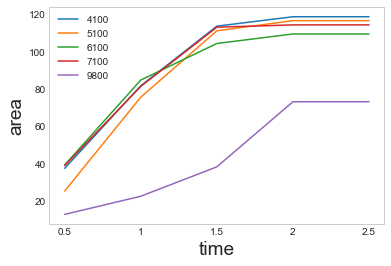

In [136]:
fig = plt.figure()
count = 0
for i in stops_df.index:
    if stops_df.loc[i, 'size'] != 1:
        area = plot_detail(stops_df, i)
        plt.plot(area, label = str(i))
        plt.xlabel('time', fontsize = 19)
        plt.ylabel('area', fontsize = 19)
        plt.grid(b = None)
        plt.legend()
        plt.xticks(np.arange(5), (0.5,1,1.5,2,2.5))
        count += 1
    if count == 5:
        break;

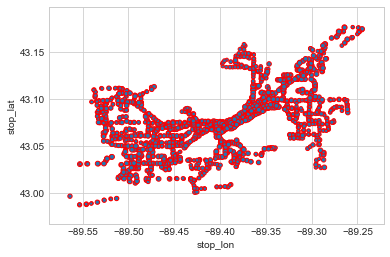

In [120]:
ax = None
ax = stops_df.plot.scatter(x="stop_lon", y="stop_lat", s=subset["size"]/10, ax=ax, facecolors = 'none', edgecolors = 'r')